# Algoritmo de Canny

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

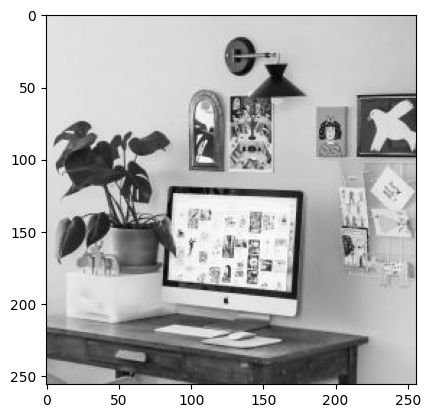

In [2]:
image = cv2.imread('../../IMAGES/2workspace.jpg', 0)
img = np.copy(image)
wid, hght = img.shape
plt.imshow(image,  cmap='gray')

In [3]:
def convolucion(image, height, width, kernel, k_size):
    pad = k_size // 2
    new_image = np.zeros((height, width), dtype=np.float32)

    for i in range(pad, height - pad):
        for j in range(pad, width - pad):
            new_image[i, j] = np.sum(image[i - pad:i + pad + 1, j - pad:j + pad + 1] * kernel)

    return new_image

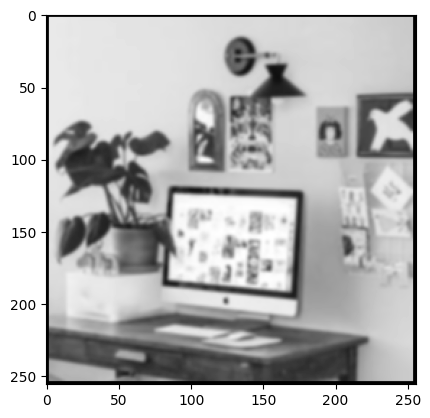

In [4]:
gauss = [[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]]
kernel_gauss = np.divide(gauss, 256)
newImage_gauss = convolucion(img,hght, wid, kernel_gauss,5)
plt.imshow(newImage_gauss, cmap='gray')

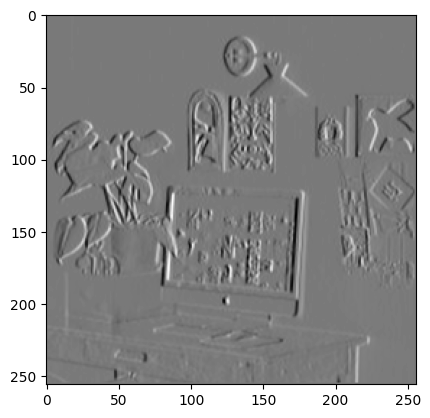

In [5]:
kernel_sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
newImage_sobel_x = convolucion(img,hght, wid, kernel_sobel_x,3)
plt.imshow(newImage_sobel_x, cmap='gray')

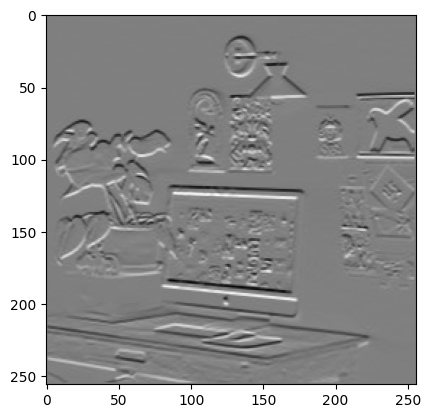

In [6]:
kernel_sobel_y = [[-1, -2, -1],[0, 0, 0],[1, 2, 1]]
newImage_sobel_y = convolucion(img,hght, wid, kernel_sobel_y,3)
plt.imshow(newImage_sobel_y, cmap='gray')

In [7]:
def canny(image, low_threshold, high_threshold):
    # Paso 1: Suavizado de la imagen
    image = newImage_gauss

    # Paso 2: Cálculo de gradientes (Sobel)
    gradient_x = newImage_sobel_x
    gradient_y = newImage_sobel_y

    # Magnitud del gradiente y dirección
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * (180 / np.pi)

    # Paso 3: Supresión de no máximos
    gradient_magnitude_suppressed = np.copy(gradient_magnitude)

    for i in range(1, wid - 1):
        for j in range(1, hght - 1):
            angle = gradient_direction[i, j]
            mag = gradient_magnitude_suppressed[i, j]
            
            # Definir los índices de los píxeles vecinos
            i_n, j_n = i, j

            if (0 <= angle < 22.5) or (157.5 <= angle <= 180) or (-22.5 <= angle < 0) or (-180 <= angle < -157.5):
                j_n += 1
            elif (22.5 <= angle < 67.5) or (-157.5 <= angle < -112.5):
                i_n -= 1
                j_n += 1
            elif (67.5 <= angle < 112.5) or (-112.5 <= angle < -67.5):
                i_n -= 1
            elif (112.5 <= angle < 157.5) or (-67.5 <= angle < -22.5):
                i_n -= 1
                j_n -= 1

            # Comprobar si el píxel actual es un máximo local
            if mag < gradient_magnitude_suppressed[i_n:i_n+2, j_n:j_n+2].max():
                gradient_magnitude_suppressed[i, j] = 0

    # Umbralización (Hysteresis)
    edges = np.zeros((wid, hght))
    strong_edge_i, strong_edge_j = np.where(gradient_magnitude_suppressed > high_threshold)
    weak_edge_i, weak_edge_j = np.where((gradient_magnitude_suppressed >= low_threshold) & (gradient_magnitude_suppressed <= high_threshold))

    edges[strong_edge_i, strong_edge_j] = 255

    for idx in range(len(weak_edge_i)):
        i, j = weak_edge_i[idx], weak_edge_j[idx]
        if np.any(edges[i-1:i+2, j-1:j+2] == 255):
            edges[i, j] = 255

    return edges.astype(np.uint8)

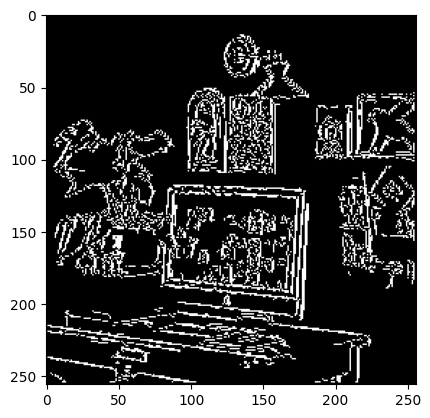

In [8]:
img_canny = canny(img, 50, 150)
plt.imshow(img_canny, cmap='gray')